In [14]:
import re 
import nltk 
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import csv

# Read in the data
data_path = '/Users/anojan/Documents/GitHub/TextProcessing/branded_food.csv'
data = pd.read_csv(data_path)

companies = [
    "Wal-Mart Stores, Inc.", "Target Stores", "Topco Associates, Inc.",
    "Safeway, Inc.", "Meijer, Inc.", "Hy-Vee, Inc.", "The Kroger Co.",
    "GENERAL MILLS SALES INC.", "Supervalu, Inc.", "Whole Foods Market, Inc."
]

data = data[data['brand_owner'].isin(companies)]


data.head()

/var/folders/s1/jgnzqdv93631smnt2ws2mv340000gn/T/ipykernel_12630/1115686647.py:13: DtypeWarning: Columns (2,3,4,6,9,12,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path)


,fdc_id,brand_owner,brand_name,subbrand_name,gtin_upc,ingredients,not_a_significant_source_of,serving_size,serving_size_unit,household_serving_fulltext,branded_food_category,data_source,package_weight,modified_date,available_date,market_country,discontinued_date,preparation_state_code,trade_channel,short_description
176,1106080,The Kroger Co.,NaN,NaN,11110848802,"ORGANIC STRAWBERRIES, ORGANIC PEACHES, ORGANIC...",NaN,140.0,g,NaN,Frozen Fruit & Fruit Juice Concentrates,LI,NaN,2020-04-08,2020-11-13,United States,NaN,NaN,NaN,NaN
193,1106097,The Kroger Co.,NaN,NaN,11110863317,"BROWN RICE FLOUR, POTATO STARCH, SAFFLOWER OIL...",NaN,30.0,g,NaN,Crackers & Biscotti,LI,NaN,2020-04-08,2020-11-13,United States,NaN,NaN,NaN,NaN
218,1106122,"Whole Foods Market, Inc.",NaN,NaN,99482434106,"CULTURED PASTEURIZED MILK, SALT, MICROBIAL ENZ...",NaN,28.0,g,NaN,Cheese,LI,NaN,2020-04-08,2020-11-13,United States,NaN,NaN,NaN,NaN
231,1106135,"Topco Associates, Inc.",NaN,NaN,36800113367,"WATER, TOMATO PUREE (WATER, TOMATO PASTE), CAR...",NaN,245.0,g,NaN,Canned Soup,LI,NaN,2020-01-09,2020-11-13,United States,NaN,NaN,NaN,NaN
253,1106157,"Wal-Mart Stores, Inc.",NaN,NaN,78742372198,"SUGAR, CORNSTARCH.",NaN,30.0,g,NaN,"Granulated, Brown & Powdered Sugar",LI,NaN,2020-04-08,2020-11-13,United States,NaN,NaN,NaN,NaN


In [18]:
filtered_data = data[['gtin_upc', 'ingredients', 'modified_date', 'brand_owner']]
filtered_data.head()


,gtin_upc,ingredients,modified_date,brand_owner
176,11110848802,"ORGANIC STRAWBERRIES, ORGANIC PEACHES, ORGANIC...",2020-04-08,The Kroger Co.
193,11110863317,"BROWN RICE FLOUR, POTATO STARCH, SAFFLOWER OIL...",2020-04-08,The Kroger Co.
218,99482434106,"CULTURED PASTEURIZED MILK, SALT, MICROBIAL ENZ...",2020-04-08,"Whole Foods Market, Inc."
231,36800113367,"WATER, TOMATO PUREE (WATER, TOMATO PASTE), CAR...",2020-01-09,"Topco Associates, Inc."
253,78742372198,"SUGAR, CORNSTARCH.",2020-04-08,"Wal-Mart Stores, Inc."


In [19]:
filtered_data['ingredient_count'] = filtered_data.groupby('gtin_upc').cumcount() + 1

# Pivot the DataFrame to create separate columns for each ingredient
aggregated_data= filtered_data.pivot(index='gtin_upc', columns='ingredient_count', values='ingredients').add_prefix('ingredients')

aggregated_data['modified_date'] = filtered_data.groupby('gtin_upc')['modified_date'].first()

# Reset the column names for clarity
aggregated_data.columns.name = None

# Reset the index
aggregated_data.reset_index(inplace=True)

aggregated_data.head()

/var/folders/s1/jgnzqdv93631smnt2ws2mv340000gn/T/ipykernel_12630/2502197430.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['ingredient_count'] = filtered_data.groupby('gtin_upc').cumcount() + 1


,gtin_upc,ingredients1,ingredients2,ingredients3,ingredients4,ingredients5,ingredients6,ingredients7,ingredients8,ingredients9,ingredients10,ingredients11,ingredients12,ingredients13,modified_date
0,1111080007,PRETZEL ROLL (ENRICHED FLOUR [BLEACHED WHEAT F...,PRETZEL ROLL (ENRICHED FLOUR [BLEACHED WHEAT F...,PRETZEL ROLL (ENRICHED FLOUR [BLEACHED WHEAT F...,PRETZEL ROLL (ENRICHED FLOUR [BLEACHED WHEAT F...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-07-14
1,1111083996,"CHICKEN BROTH (CONTAINS ASCORBIC ACID, FLAVOR)...","CHICKEN BROTH (CONTAINS ASCORBIC ACID, FLAVOR)...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-28
2,1111087099,"ICE CREAM: MILK FAT AND NONFAT MILK, BUTTERMIL...","ICE CREAM: MILK FAT AND NONFAT MILK, BUTTERMIL...","ICE CREAM: MILK FAT AND NONFAT MILK, BUTTERMIL...","ICE CREAM: MILK FAT AND NONFAT MILK, BUTTERMIL...","ICE CREAM: MILK FAT AND NONFAT MILK, BUTTERMIL...","ICE CREAM: MILK FAT AND NONFAT MILK, BUTTERMIL...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-06
3,1111088133,"WATER, CREAM (CREAM, MILK, CARRAGEENAN, MONO-&...","WATER, CREAM (CREAM, MILK, CARRAGEENAN, MONO-&...","WATER, CREAM (CREAM, MILK, CARRAGEENAN, MONO-&...","WATER, CREAM (CREAM, MILK, CARRAGEENAN, MONO-&...","WATER, CREAM (CREAM, MILK, CARRAGEENAN, MONO-&...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-20
4,1116103494,"CASHEWS, VEGETABLE OIL (PEANUT, COTTONSEED, SO...","CASHEWS, VEGETABLE OIL (PEANUT, COTTONSEED, SO...","CASHEWS, VEGETABLE OIL (PEANUT, COTTONSEED, SO...","CASHEWS, VEGETABLE OIL (PEANUT, COTTONSEED, SO...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-20


In [22]:
aggregated_data = aggregated_data.dropna(subset=['ingredients2'])
aggregated_data.head()

,gtin_upc,ingredients1,ingredients2,ingredients3,ingredients4,ingredients5,ingredients6,ingredients7,ingredients8,ingredients9,ingredients10,ingredients11,ingredients12,ingredients13,modified_date
0,1111080007,PRETZEL ROLL (ENRICHED FLOUR [BLEACHED WHEAT F...,PRETZEL ROLL (ENRICHED FLOUR [BLEACHED WHEAT F...,PRETZEL ROLL (ENRICHED FLOUR [BLEACHED WHEAT F...,PRETZEL ROLL (ENRICHED FLOUR [BLEACHED WHEAT F...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-07-14
1,1111083996,"CHICKEN BROTH (CONTAINS ASCORBIC ACID, FLAVOR)...","CHICKEN BROTH (CONTAINS ASCORBIC ACID, FLAVOR)...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-28
2,1111087099,"ICE CREAM: MILK FAT AND NONFAT MILK, BUTTERMIL...","ICE CREAM: MILK FAT AND NONFAT MILK, BUTTERMIL...","ICE CREAM: MILK FAT AND NONFAT MILK, BUTTERMIL...","ICE CREAM: MILK FAT AND NONFAT MILK, BUTTERMIL...","ICE CREAM: MILK FAT AND NONFAT MILK, BUTTERMIL...","ICE CREAM: MILK FAT AND NONFAT MILK, BUTTERMIL...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-06
3,1111088133,"WATER, CREAM (CREAM, MILK, CARRAGEENAN, MONO-&...","WATER, CREAM (CREAM, MILK, CARRAGEENAN, MONO-&...","WATER, CREAM (CREAM, MILK, CARRAGEENAN, MONO-&...","WATER, CREAM (CREAM, MILK, CARRAGEENAN, MONO-&...","WATER, CREAM (CREAM, MILK, CARRAGEENAN, MONO-&...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-20
4,1116103494,"CASHEWS, VEGETABLE OIL (PEANUT, COTTONSEED, SO...","CASHEWS, VEGETABLE OIL (PEANUT, COTTONSEED, SO...","CASHEWS, VEGETABLE OIL (PEANUT, COTTONSEED, SO...","CASHEWS, VEGETABLE OIL (PEANUT, COTTONSEED, SO...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-20


In [23]:
aggregated_data_2 = aggregated_data[['gtin_upc', 'ingredients1', 'ingredients2', 'modified_date']]
aggregated_data_2.head()

,gtin_upc,ingredients1,ingredients2,modified_date
0,1111080007,PRETZEL ROLL (ENRICHED FLOUR [BLEACHED WHEAT F...,PRETZEL ROLL (ENRICHED FLOUR [BLEACHED WHEAT F...,2017-07-14
1,1111083996,"CHICKEN BROTH (CONTAINS ASCORBIC ACID, FLAVOR)...","CHICKEN BROTH (CONTAINS ASCORBIC ACID, FLAVOR)...",2020-07-28
2,1111087099,"ICE CREAM: MILK FAT AND NONFAT MILK, BUTTERMIL...","ICE CREAM: MILK FAT AND NONFAT MILK, BUTTERMIL...",2019-05-06
3,1111088133,"WATER, CREAM (CREAM, MILK, CARRAGEENAN, MONO-&...","WATER, CREAM (CREAM, MILK, CARRAGEENAN, MONO-&...",2018-01-20
4,1116103494,"CASHEWS, VEGETABLE OIL (PEANUT, COTTONSEED, SO...","CASHEWS, VEGETABLE OIL (PEANUT, COTTONSEED, SO...",2018-01-20


In [25]:
ingredients_text = '\n'.join(aggregated_data_2['ingredients1'].dropna())
ingredients_text2 = '\n'.join(aggregated_data_2['ingredients2'].dropna())

# Write the concatenated text to a file
with open('ingredients_text.txt', 'w', encoding='utf-8') as file:
    file.write(ingredients_text)
    file.write(ingredients_text2)

# Confirm completion
print("Ingredients text written to ingredients_text.txt")

Ingredients text written to ingredients_text.txt


In [28]:
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Read the text file
with open('ingredients_text.txt', 'r', encoding='utf-8') as file:
    text = file.read()

# Preprocess the text: tokenize, remove punctuation and stopwords
tokens = word_tokenize(text)
tokens = [word.lower() for word in tokens if word.isalpha()]  # Remove punctuation and make lowercase
stop_words = set(stopwords.words('english'))

tokens = [word for word in tokens if word not in stop_words]

# Train Word2Vec model
model = Word2Vec([tokens], vector_size=100, window=5, min_count=1, workers=4)

# Now, you can use the model to find word vectors or relationships
# Example: model.wv.most_similar('sugar', topn=5)
model.wv.most_similar('sugar', topn=5)

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>


[('oil', 0.9995458722114563),
 ('coconut', 0.9994956851005554),
 ('hydrogenated', 0.9994139075279236),
 ('peanut', 0.9993967413902283),
 ('contains', 0.999387800693512)]

In [27]:
pip install -U gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 19.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 1.2 MB/s eta 0:00:00ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [29]:
pip install matplotlib wordcloud


Note: you may need to restart the kernel to use updated packages.


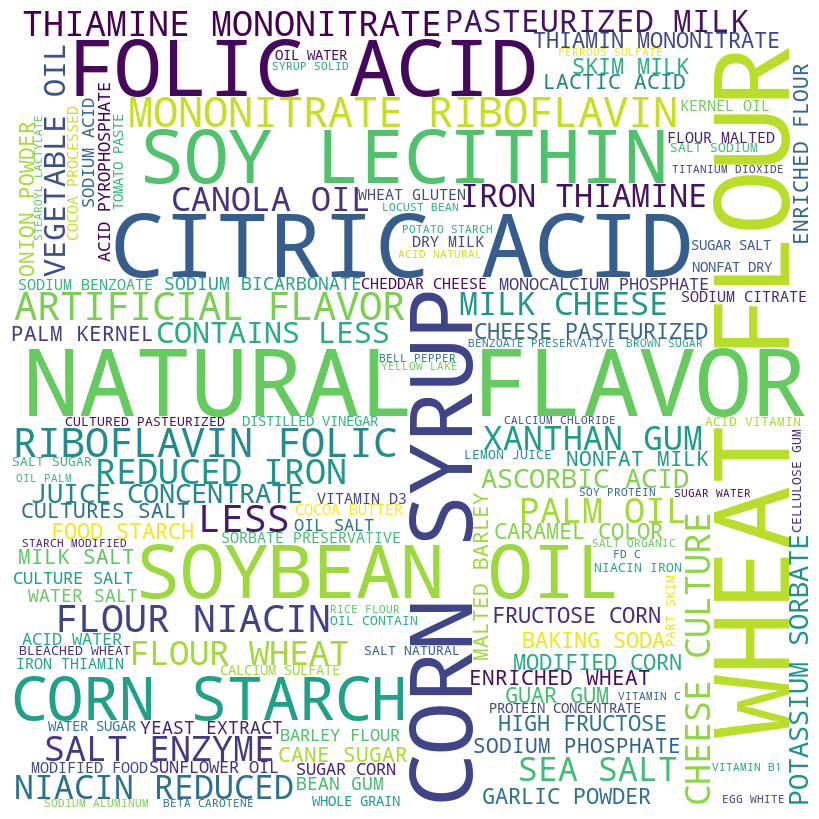

In [30]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Read the text file
with open('ingredients_text.txt', 'r', encoding='utf-8') as file:
    text = file.read()

# Generate a word cloud
wordcloud = WordCloud(width=800, height=800, 
                      background_color='white', 
                      min_font_size=10).generate(text)

# Plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


In [31]:
# Replace 'ingredients_text.txt' with the correct path to your file
file_path = 'ingredients_text.txt'

# Read the text file and get its length
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()
    text_length = len(text)

print(f"Length of the text file: {text_length} characters")


Length of the text file: 37338107 characters


In [32]:
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
import string

# Read the text file
with open('ingredients_text.txt', 'r', encoding='utf-8') as file:
    text = file.read()

# Tokenize the text and remove punctuation
tokens = word_tokenize(text)
tokens = [word.lower() for word in tokens if word.isalpha()]

# Count the frequency of each word
word_freq = Counter(tokens)


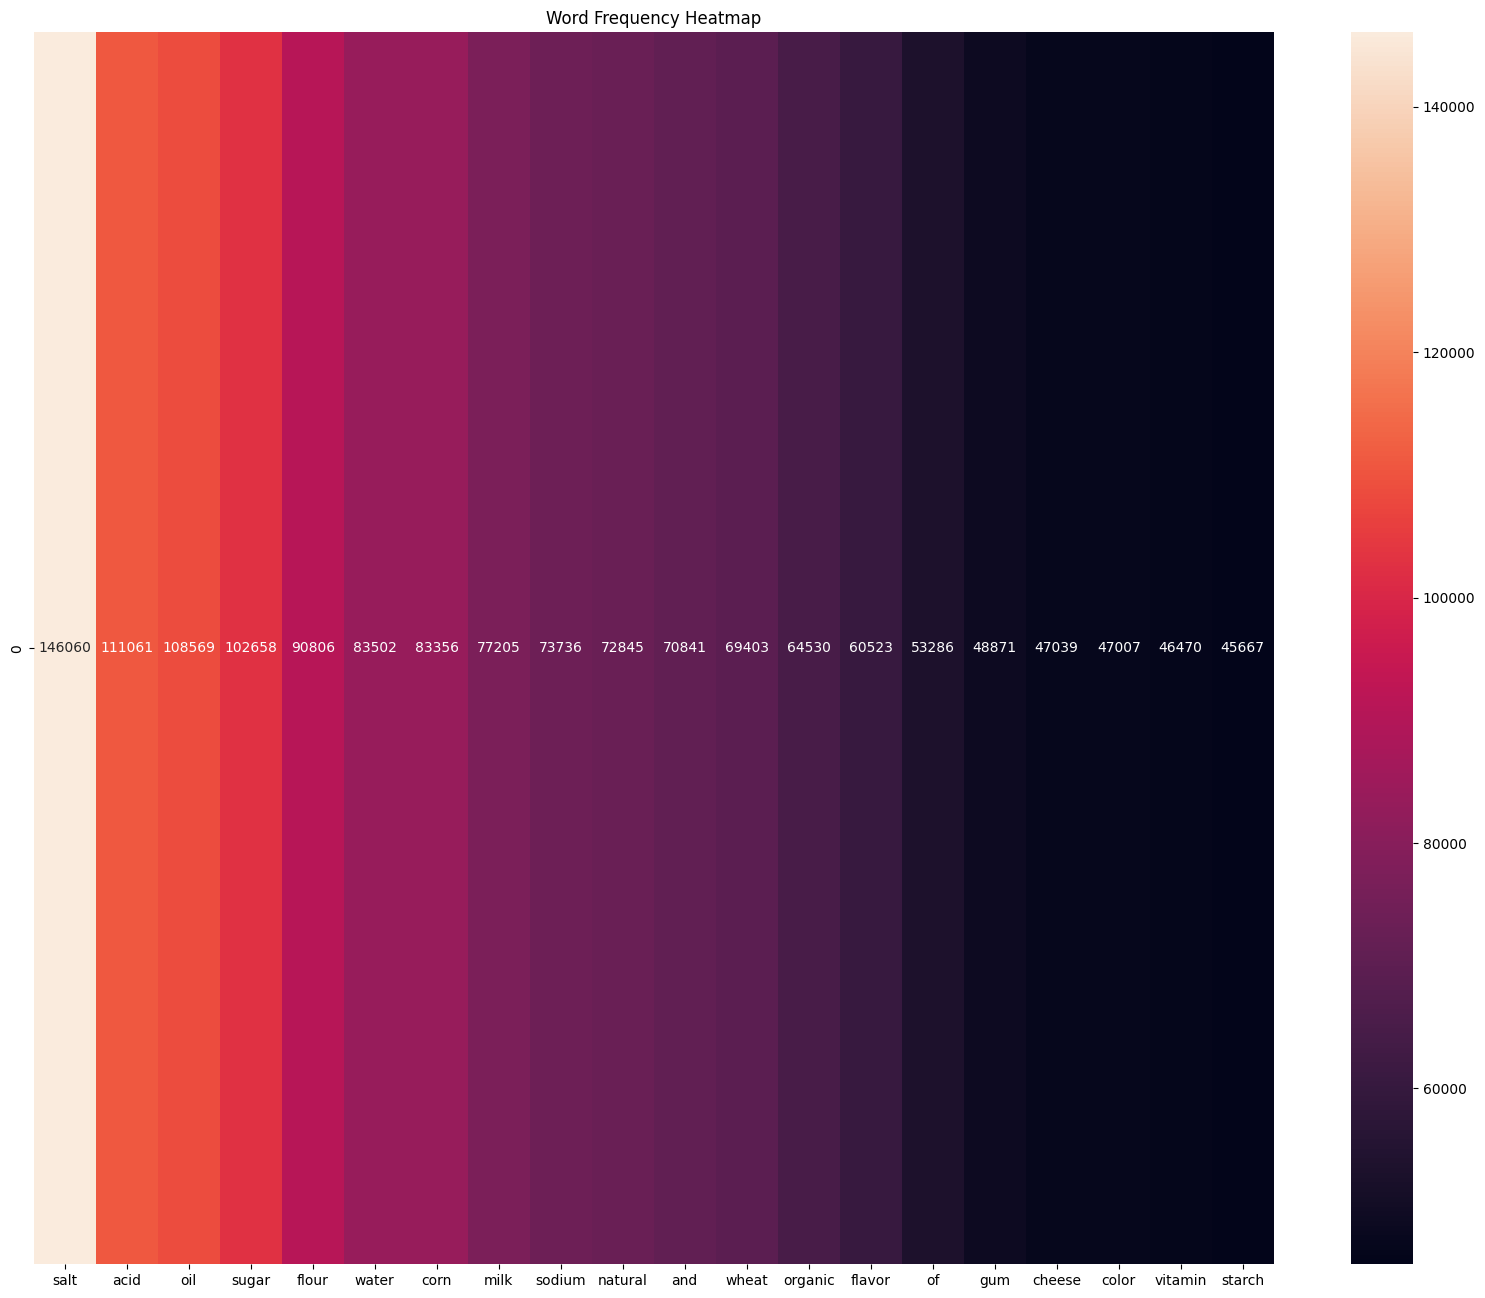

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Take the most common words for the heatmap
most_common_words = word_freq.most_common(20)  # Adjust the number as needed
labels, counts = zip(*most_common_words)

# Create a heatmap
plt.figure(figsize=(20, 16))
sns.heatmap([counts], annot=True, xticklabels=labels, fmt="d")
plt.title("Word Frequency Heatmap")
plt.show()


In [34]:
pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 4.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
